<!--TITLE: Convolution and ReLU-->

In [1]:

import numpy as np
from itertools import product

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

# Introduction #

In the last lesson, we saw that a convolutional classifier has two parts: a convolutional **base** and a **head** of dense layers. We learned that the job of the base is to extract visual features from an image, which the head would then use to classify the image.

Over the next few lessons, we're going to learn about the two most important types of layers that you'll usually find in the base of a convolutional image classifier. These are the **convolutional layer** with **ReLU activation**, and the **maximum pooling layer**. In Lesson 5, you'll learn how to design your own convnet by composing these layers into blocks that perform the feature extraction.

This lesson is about the convolutional layer with its ReLU activation function.

# Feature Extraction #

Before we get into the details of convolution, let's discuss the *purpose* of these layers in the network. We're going to see how these three operations (convolution, ReLU, and maximum pooling) are used to implement the feature extraction process.

The **feature extraction** performed by the base consists of **three basic operations**:
1. **Filter** an image for a particular feature (convolution)
2. **Detect** that feature within the filtered image (ReLU)
3. **Condense** the image to enhance the features (maximum pooling)

The next figure illustrates this process. You can see how these three operations are able to isolate some particular characteristic of the original image (in this case, horizontal lines).

<figure>
<!-- <img src="./images/2-show-extraction.png" width="1200" alt="An example of the feature extraction process."> -->
<img src="https://i.imgur.com/IYO9lqp.png" width="600" alt="An example of the feature extraction process.">
<figcaption style="textalign: center; font-style: italic"><center>The three steps of feature extraction.</center></figcaption>
</figure>

Typically, the network will perform several extractions in parallel on a single image. In modern convnets, it's not uncommon for the final layer in the base to be producing over 1000 unique visual features.

# Filter with Convolution #

A convolutional layer carries out the filtering step. You might define a convolutional layer in a Keras model something like this:

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    # More layers follow
])

2022-05-05 17:53:45.814211: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


We can understand these parameters by looking at their relationship to the *weights* and *activations* of the layer. Let's do that now.

## Weights ##

The **weights** a convnet learns during training are primarily contained in its convolutional layers. These weights we call **kernels**. We can represent them as small arrays:

<figure>
<!-- <img src="./images/3-kernel.png" width="150" alt="A 3x3 kernel."> -->
<img src="https://i.imgur.com/uJfD9r9.png" width="150" alt="A 3x3 kernel.">
</figure>

A kernel operates by scanning over an image and producing a *weighted sum* of pixel values. In this way, a kernel will act sort of like a polarized lens, emphasizing or deemphasizing certain patterns of information.

<figure>
<!-- <img src="./images/3-kernel-lens.png" width="400" alt="A kernel acts as a kind of lens."> -->
<img src="https://i.imgur.com/j3lk26U.png" width="250" alt="A kernel acts as a kind of lens.">
<figcaption style="textalign: center; font-style: italic"><center>A kernel acts as a kind of lens.</center></figcaption>
</figure>

Kernels define how a convolutional layer is connected to the layer that follows. The kernel above will connect each neuron in the output to nine neurons in the input. By setting the dimensions of the kernels with `kernel_size`, you are telling the convnet how to form these connections. Most often, a kernel will have odd-numbered dimensions -- like `kernel_size=(3, 3)` or `(5, 5)` -- so that a single pixel sits at the center, but this is not a requirement.

The kernels in a convolutional layer determine what kinds of features it creates. During training, a convnet tries to learn what features it needs to solve the classification problem. This means finding the best values for its kernels.

<!--TODO: Learning a kernel-->

## Activations ##

The **activations** in the network we call **feature maps**. They are what result when we apply a filter to an image; they contain the visual features the kernel extracts. Here are a few kernels pictured with feature maps they produced.

<figure>
<img src="https://i.imgur.com/JxBwchH.png" width="800" alt="Three kernels and the feature maps they produce."><figcaption style="textalign: center; font-style: italic"><center>Kernels and features.</center></figcaption>
</figure>

From the pattern of numbers in the kernel, you can tell the kinds of feature maps it creates. Generally, what a convolution accentuates in its inputs will match the shape of the *positive* numbers in the kernel. The left and middle kernels above will both filter for horizontal shapes.

With the `filters` parameter, you tell the convolutional layer how many feature maps you want it to create as output.

# Detect with ReLU #

After filtering, the feature maps pass through the activation function. The **rectifier function** has a graph like this:

<figure>
<!-- <img src="./images/relu.png" width="300" alt=""> -->
<img src="https://i.imgur.com/DxGJuTH.png" width="300" alt="Graph of the ReLU activation function.">
<figcaption style="textalign: center; font-style: italic"><center>The graph of the rectifier function looks like a line with the negative part "rectified" to 0.</center></figcaption>
</figure>

A neuron with a rectifier attached is called a *rectified linear unit*. For that reason, we might also call the rectifier function the **ReLU activation** or even the ReLU function.

The ReLU activation can be defined in its own `Activation` layer, but most often you'll just include it as the activation function of `Conv2D`.

In [3]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu')
    # More layers follow
])

You could think about the activation function as scoring pixel values according to some measure of importance. The ReLU activation says that negative values are not important and so sets them to 0. ("Everything unimportant is equally unimportant.")

Here is ReLU applied the feature maps above. Notice how it succeeds at isolating the features.

<figure>
<!-- <img src="./images/3-relu-and-maps.png" width="800" alt="ReLU applied to feature maps."> -->
<img src="https://i.imgur.com/dKtwzPY.png" width="800" alt="ReLU applied to feature maps.">
</figure>

Like other activation functions, the ReLU function is **nonlinear**. Essentially this means that the total effect of all the layers in the network becomes different than what you would get by just adding the effects together -- which would be the same as what you could achieve with only a single layer. The nonlinearity ensures features will combine in interesting ways as they move deeper into the network. (We'll explore this "feature compounding" more in Lesson 5.)

# Example - Apply Convolution and ReLU #

We'll do the extraction ourselves in this example to understand better what convolutional networks are doing "behind the scenes".

Here is the image we'll use for this example:

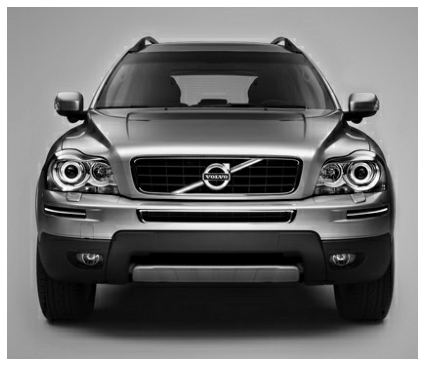

In [4]:

import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image_path = '../input/computer-vision-resources/car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show();

For the filtering step, we'll define a kernel and then apply it with the convolution. The kernel in this case is an "edge detection" kernel. You can define it with `tf.constant` just like you'd define an array in Numpy with `np.array`. This creates a *tensor* of the sort TensorFlow uses.

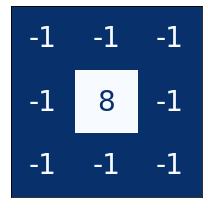

In [5]:
import tensorflow as tf

kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
])

plt.figure(figsize=(3, 3))
show_kernel(kernel)

TensorFlow includes many common operations performed by neural networks in its `tf.nn` [module](https://www.tensorflow.org/api_docs/python/tf/nn). The two that we'll use are `conv2d` and `relu`. These are simply function versions of Keras layers.

This next hidden cell does some reformatting to make things compatible with TensorFlow. The details aren't important for this example.

In [6]:

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

Now let's apply our kernel and see what happens.

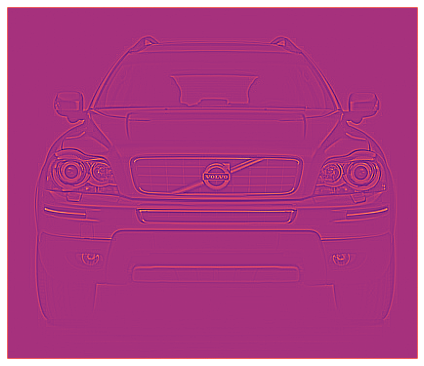

In [7]:
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # we'll talk about these two in lesson 4!
    strides=1,
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.show();

Next is the detection step with the ReLU function. This function is much simpler than the convolution, as it doesn't have any parameters to set.

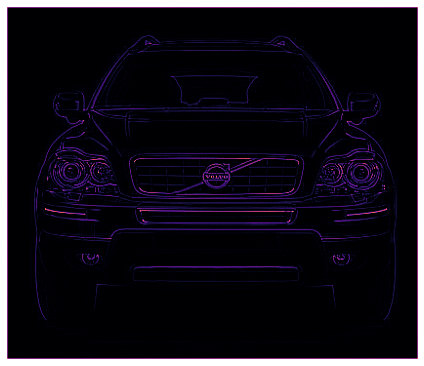

In [8]:
image_detect = tf.nn.relu(image_filter)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.show();

And now we've created a feature map! Images like these are what the head uses to solve its classification problem. We can imagine that certain features might be more characteristic of *Cars* and others more characteristic of *Trucks*. The task of a convnet during training is to create kernels that can find those features.

# Conclusion #

We saw in this lesson the first two steps a convnet uses to perform feature extraction: **filter** with `Conv2D` layers and **detect** with `relu` activation.

# Your Turn #

In [**the exercises**](https://www.kaggle.com/kernels/fork/11989557), you'll have a chance to experiment with the kernels in the pretrained VGG16 model we used in Lesson 1.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/computer-vision/discussion) to chat with other learners.*